<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span><ul class="toc-item"><li><span><a href="#Создание-собственных-функций" data-toc-modified-id="Создание-собственных-функций-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Создание собственных функций</a></span></li></ul></li><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#purchases" data-toc-modified-id="purchases-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><code>purchases</code></a></span></li><li><span><a href="#messages" data-toc-modified-id="messages-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><code>messages</code></a></span></li><li><span><a href="#target" data-toc-modified-id="target-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span><code>target</code></a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Корреляционный анализ</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Оценка-модели-с-использованием-метрики-ROC-AUC" data-toc-modified-id="Оценка-модели-с-использованием-метрики-ROC-AUC-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Оценка модели с использованием метрики ROC-AUC</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Исследование для интернет-магазина

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель**

Предсказать вероятность покупки в течение 90 дней

**Задачи**

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

## Описание данных

1. `apparel-purchases` **история покупок**

- `client_id` идентификатор пользователя
- `quantity` количество товаров в заказе
- `price` цена товара
- `category_ids` вложенные категории, к которым отнсится товар
- `date` дата покупки
- `message_id` идентификатор сообщения из рассылки

2. `apparel-messages` **история рекламных рассылок**

- `bulk_campaign_id` идентификатор рекламной кампании
- `client_id` идентификатор пользователя
- `message_id` идентификатор сообщений
- `event` тип действия
- `channel` канал рассылки
- `date` дата рассылки
- `created_at` точное время создания сообщения

3. `apparel-target_binary` **совершит ли клиент покупку в течение следующих 90 дней**

- `client_id` идентификатор пользователя
- `target` целевой признак

Агрегированная по дням статистика по рассылкам из общей базы рассылок:

1. `full_campaign_daily_event` **Агрегация общей базы рассылок по дням и типам событий**
- `date` дата
- `bulk_campaign_id` идентификатор рассылки
- `count_event`* общее количество каждого события event
- `nunique_event* количество уникальных client_id в каждом событии

* в именах колонок все типы событий event

2. `full_campaign_daily_event_channel` **Агрегация по дням с учетом событий и каналов рассылки**
- `date` дата
- `bulk_campaign_id` идентификатор рассылки
- `count_event_channel`* общее количество каждого события по каналам
- `nunique_event_channel`* количество уникальных client_id по событиям и каналам

### Создание собственных функций

Функция для вывода основной информации о датафрейме:

In [131]:
def information_data(data):
    display('Общая информация о датафрейме:')
    display(data.info())
    display('Описание данных:')
    display(data.describe())    
    display('Первые десять строк датафрейма:')
    display(data.head(10))
    display('Количество пропусков:')
    display(data.isna().sum())
    display('Количество дубликатов:')
    display(data.duplicated().sum())

Функция для построения гистограммы и диаграммы размаха для проведения исследовательского анализа количественных признаков:

In [132]:
def hist_boxplot(data, features, color='indigo'):
    for col in features:
        fig, axs = plt.subplots(1, 2, figsize=(20, 5))

        # Гистограмма
        axs[0].hist(data[col], color=color, edgecolor='black', alpha=0.5, range=(2, data[col].max()))
        axs[0].set_title(f'Гистограмма для {col}', fontsize=15)
        axs[0].set_xlabel(col)  
        axs[0].set_ylabel('count')  

        # Диаграмма размаха
        sns.boxplot(x=data[col], ax=axs[1], color=color)
        axs[1].set_title(f'Диаграмма размаха для {col}', fontsize=15)
        axs[1].set_xlabel(col)  

        plt.show()

Функция для построения круговой диаграммы для категориальных признаков:

In [133]:
colors = ['lightpink', 'powderblue', 'wheat', 'lightcoral', 'skyblue']

def plot_pie(data, features, xlbl=None):
    for col in features:
        plt.figure(figsize=(10, 7))
        random_colors = random.sample(colors, len(colors))
        ax = data[col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=random_colors)
        plt.title(f'Круговая диаграмма {col}')
        plt.xlabel(xlbl)
        ax.set_ylabel('')  
        plt.show()

In [134]:
def plot_bar_top_10(data, features, column_names, ylbl=None, xlbl=None):
    for col in features:
        plt.figure(figsize=(10, 7))
        # Сортируем значения и берём 10 самых популярных
        top_10 = data[col].value_counts().nlargest(10).sort_values(ascending=True)
        top_10.plot(kind='barh', color='thistle', edgecolor='dimgrey')
        plt.title(f'Горизонтальная столбчатая диаграмма для {column_names[col]} (Топ-10 категорий)')
        plt.xlabel(xlbl)
        plt.ylabel(ylbl)
        plt.show();


Объявляем константы

In [135]:
RANDOM_STATE = 42

## Загрузка и предобработка данных

In [136]:
pip install --upgrade shap --user


Note: you may need to restart the kernel to use updated packages.


In [137]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import time
from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)
from collections import Counter

from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import phik
import sklearn
import shap

Загрузим файлы

In [138]:
try:
    purchases = pd.read_csv('C:\\python\\datasets\\apparel-purchases.csv', parse_dates=['date'])
    messages = pd.read_csv('C:\\python\\datasets\\apparel-messages.csv', parse_dates=['date', 'created_at'])
    target = pd.read_csv('C:\\python\\datasets\\apparel-target_binary.csv')
    
except:
    print('Файлы не обнаружены')

### `purchases`

In [139]:
information_data(purchases)

'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

'Описание данных:'

,client_id,quantity,price,date
count,2.022080e+05,202208.000000,202208.000000,202208
mean,1.515916e+18,1.006483,1193.301516,2023-03-17 02:49:35.739832064
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00
25%,1.515916e+18,1.000000,352.000000,2022-11-12 00:00:00
50%,1.515916e+18,1.000000,987.000000,2023-04-12 00:00:00
75%,1.515916e+18,1.000000,1699.000000,2023-07-03 00:00:00
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00
std,1.459514e+08,0.184384,1342.252664,NaN


'Первые десять строк датафрейма:'

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


'Количество пропусков:'

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

'Количество дубликатов:'

73020

При предварительном просмотре данных видим следующее:
- пропусков в данных нет
- типы данных в столбцах соответствуют содержимому, а также при загрузке датасета указали `parse_dates`
- столбец `category_ids` содержит списки или строки, проверим при дальнейшей обработке данных
- `message_id` содержит `id` клиента, идентификатор рекламной кампании и уникальный идентификатор сообщения
- содержится много дубликатов, оставим их без изменений, так как если их удалить, мы потеряем большое количество наблюдений, а также можно предположить (так как столбец `date` не содержит точного времени совершения покупки), что это покупки одного и того же товара или товаров из одной категории, совершенные в один день
- минимальное количество покупаемых за раз товаров — 1, максимальное — 30
- минимальная и максимальная цена товаров — 1 и 85499 соответственно
- в данных представлена информация о покупках за период с 16 мая 2022 по 16 февраля 2024 года

Явных аномалий не наблюдается, значения выглядят реалистично, кроме товаров за 1 денег, но возможно это акционные товары. Оставим без изменений. 

Из датасета `purchases` можем извлечь следующие агрегированные столбцы для каждого покупателя:
- `first_purchase_date` и `last_purchase_date` дата первой и последней покупки соответственно
- `last_purchase_month_year` категориальный столбец со временем последней покупки: месяц и год
- `purchase_count` количество совершенных покупок за весь период пользования сайтом 
- `total_spent` общая сумма совершенных покупок
- `average_purchase_value` средняя сумма покупки
- `max_purchase_value` и `min_purchase_value` максимальная и минимальная сумма покупки соответственно
- `usage_duration` продолжительность пользования сайтом (разница между датой последней и первой покупки)
- `favorite_category` для получения любимой категории возьмем первые 4 значения из столбца `category_ids` датасета `purchases`, отсортируем их по возрастанию, так как в ТЗ указано, что порядок не имеет значения и возьмем первые два из полученного списка. Таким образом мы сможем уменьшить количество уникальных значений и получим более обобщенные категории товаров. Также в ТЗ указано, что в столбце могут встречаться маркеры "для мужчин", "для женщин", "распродажа" и другие, но легенда не приводится, то есть какое именно значение в данном случае является маркером непонятно. 
- `unique_categories_count` количество уникальных категорий, в которых пользователь совершал покупки
- `average_spent_favorite` средняя цена покупки в любимой категории 	
- `active_last_30_days` и `active_last_60_days` активность в последние 30/60 дней. Бинарные признаки, 1 — если пользователь совершал покупки в последние 30/60 дней, 0 — если не совершал


In [140]:
df = purchases.groupby('client_id').agg(
    first_purchase_date=('date', 'min'),
    last_purchase_date=('date', 'max'),
    purchase_count=('date', 'count'),
    total_spent=('price', 'sum'),
    average_purchase_value=('price', lambda x: round(x.mean(), 1)),
    max_purchase_value=('price', 'max'),
    min_purchase_value=('price', 'min')
)

In [141]:
df['usage_duration'] = (df['last_purchase_date'] - df['first_purchase_date']).dt.days + 1

In [142]:
def process_category_ids(category_ids):
    if not isinstance(category_ids, list) or len(category_ids) == 0:
        return ''

    valid_ids = []
    for cat in category_ids:
        try:
            valid_ids.append(int(cat))
        except (ValueError, TypeError):
            continue

    if len(valid_ids) == 0:
        return ''

    valid_ids = sorted(valid_ids[:4])

    return '-'.join(map(str, valid_ids[:2]))


purchases['category_ids'] = purchases['category_ids'].apply(
    lambda x: ast.literal_eval(x))
purchases['top_categories'] = purchases['category_ids'].apply(
    lambda x: process_category_ids(x))

print(purchases[['category_ids', 'top_categories']].head())

        category_ids top_categories
0   [4, 28, 57, 431]           4-28
1   [4, 28, 57, 431]           4-28
2   [4, 28, 57, 431]           4-28
3  [4, 28, 244, 432]           4-28
4   [4, 28, 49, 413]           4-28


In [143]:
def get_popular_categories(categories):
    counter = Counter(categories)
    most_common = counter.most_common()
    favorite_category = most_common[0][0] if most_common else None
    unique_categories_count = len(counter)
    return favorite_category, unique_categories_count


aggregated_data = purchases.groupby('client_id').agg({
    'top_categories': lambda x: get_popular_categories(x)[0]
}).reset_index()

aggregated_data['unique_categories_count'] = purchases.groupby(
    'client_id')['top_categories'].apply(lambda x: len(set(x))).values


def get_average_spent_for_favorite(client_id, favorite_category):
    client_purchases = purchases[purchases['client_id'] == client_id]
    favorite_purchases = client_purchases[client_purchases['top_categories']
                                          == favorite_category]
    return favorite_purchases['price'].mean()


aggregated_data['average_spent_favorite'] = aggregated_data.apply(lambda row: round(
    get_average_spent_for_favorite(row['client_id'], row['top_categories']), 1), axis=1)

# переименование столбцов
aggregated_data.columns = ['client_id', 'favorite_category',
                           'unique_categories_count', 'average_spent_favorite']

In [144]:
aggregated_data.set_index('client_id', inplace=True)

In [145]:
aggregated_data

,favorite_category,unique_categories_count,average_spent_favorite
client_id,,,
1515915625468060902,4-28,2,1324.0
1515915625468061003,4-28,1,2319.3
1515915625468061099,4-28,1,299.0
1515915625468061100,4-27,1,1049.0
1515915625468061170,4-28,3,1879.3
...,...,...,...
1515915626010261344,2-18,1,1499.0
1515915626010266132,4-27,1,909.0
1515915626010439406,4-27,1,99.0


Объединим полученные датафреймы:

In [146]:
df = df.join(aggregated_data, how='left')

Создадим столбцы "активность за последние 30/60 дней":

In [147]:
df['active_last_30_days'] = (df['last_purchase_date'] >= (purchases['date'].max() - pd.Timedelta(days=30))).astype(int)
df['active_last_60_days'] = (df['last_purchase_date'] >= (purchases['date'].max() - pd.Timedelta(days=60))).astype(int)

Добавим категориальный столбец со временем последней покупки: месяц и год:

In [148]:
df['last_purchase_month_year'] = df['last_purchase_date'].dt.strftime('%m-%Y')
df['last_purchase_month_year'] = df['last_purchase_month_year'].astype('category')

In [149]:
df.reset_index(inplace=True)

Посмотрим, что у нас получилось:

In [150]:
information_data(df)

'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   first_purchase_date       49849 non-null  datetime64[ns]
 2   last_purchase_date        49849 non-null  datetime64[ns]
 3   purchase_count            49849 non-null  int64         
 4   total_spent               49849 non-null  float64       
 5   average_purchase_value    49849 non-null  float64       
 6   max_purchase_value        49849 non-null  float64       
 7   min_purchase_value        49849 non-null  float64       
 8   usage_duration            49849 non-null  int64         
 9   favorite_category         49849 non-null  object        
 10  unique_categories_count   49849 non-null  int64         
 11  average_spent_favorite    49849 non-null  float64       
 12  active_last_30_day

None

'Описание данных:'

,client_id,first_purchase_date,last_purchase_date,purchase_count,total_spent,average_purchase_value,max_purchase_value,min_purchase_value,usage_duration,unique_categories_count,average_spent_favorite,active_last_30_days,active_last_60_days
count,4.984900e+04,49849,49849,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,4.056410,4840.520632,1483.414925,1792.131377,1238.219884,22.132199,1.525086,1479.201693,0.033662,0.087364
min,1.515916e+18,2022-05-16 00:00:00,2022-05-16 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.515916e+18,2022-08-03 00:00:00,2022-08-23 00:00:00,1.000000,1499.000000,699.000000,910.000000,399.000000,1.000000,1.000000,625.000000,0.000000,0.000000
50%,1.515916e+18,2022-12-26 00:00:00,2023-03-05 00:00:00,2.000000,2929.000000,1249.000000,1499.000000,999.000000,1.000000,1.000000,1260.000000,0.000000,0.000000
75%,1.515916e+18,2023-06-14 00:00:00,2023-06-28 00:00:00,5.000000,5677.000000,1999.000000,2199.000000,1749.000000,1.000000,2.000000,1999.000000,0.000000,0.000000
max,1.515916e+18,2024-02-16 00:00:00,2024-02-16 00:00:00,346.000000,540408.000000,53499.000000,85499.000000,53499.000000,637.000000,33.000000,53499.000000,1.000000,1.000000
std,1.487947e+08,NaN,NaN,5.521669,7312.865458,1388.178152,1647.320646,1384.678770,76.842637,1.166806,1427.588438,0.180359,0.282370


'Первые десять строк датафрейма:'

,client_id,first_purchase_date,last_purchase_date,purchase_count,total_spent,average_purchase_value,max_purchase_value,min_purchase_value,usage_duration,favorite_category,unique_categories_count,average_spent_favorite,active_last_30_days,active_last_60_days,last_purchase_month_year
0,1515915625468060902,2022-05-27,2022-05-27,7,6993.0,999.0,1999.0,199.0,1,4-28,2,1324.0,0,0,05-2022
1,1515915625468061003,2023-01-04,2023-01-04,7,16235.0,2319.3,3499.0,1749.0,1,4-28,1,2319.3,0,0,01-2023
2,1515915625468061099,2022-05-17,2022-05-17,1,299.0,299.0,299.0,299.0,1,4-28,1,299.0,0,0,05-2022
3,1515915625468061100,2024-02-10,2024-02-10,2,2098.0,1049.0,1049.0,1049.0,1,4-27,1,1049.0,1,1,02-2024
4,1515915625468061170,2023-03-26,2023-06-17,19,33601.0,1768.5,2699.0,7.0,84,4-28,3,1879.3,0,0,06-2023
5,1515915625468061514,2022-07-30,2022-07-30,1,999.0,999.0,999.0,999.0,1,4-28,1,999.0,0,0,07-2022
6,1515915625468061877,2022-08-19,2022-08-19,1,1499.0,1499.0,1499.0,1499.0,1,1829-5562,1,1499.0,0,0,08-2022
7,1515915625468061975,2022-07-27,2022-07-27,1,299.0,299.0,299.0,299.0,1,4-1848,1,299.0,0,0,07-2022
8,1515915625468061994,2022-11-15,2022-12-14,8,1012.0,126.5,199.0,79.0,30,1848-6058,4,159.0,0,0,12-2022
9,1515915625468062158,2022-05-23,2023-04-28,4,6096.0,1524.0,2499.0,699.0,341,4-28,1,1524.0,0,0,04-2023


'Количество пропусков:'

client_id                   0
first_purchase_date         0
last_purchase_date          0
purchase_count              0
total_spent                 0
average_purchase_value      0
max_purchase_value          0
min_purchase_value          0
usage_duration              0
favorite_category           0
unique_categories_count     0
average_spent_favorite      0
active_last_30_days         0
active_last_60_days         0
last_purchase_month_year    0
dtype: int64

'Количество дубликатов:'

0

### `messages`

In [151]:
information_data(messages)

'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


None

'Описание данных:'

,bulk_campaign_id,client_id,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798
mean,1.160459e+04,1.515916e+18,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,5.480000e+02,1.515916e+18,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,8.746000e+03,1.515916e+18,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,1.351600e+04,1.515916e+18,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,1.415800e+04,1.515916e+18,2023-11-21 00:00:00,2023-11-21 18:13:05
max,1.465700e+04,1.515916e+18,2024-02-15 00:00:00,2024-02-15 23:58:40
std,3.259211e+03,3.265518e+08,NaN,NaN


'Первые десять строк датафрейма:'

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


'Количество пропусков:'

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

'Количество дубликатов:'

48610

В данном случае удалить дубликаты можно безболезненно, так как они составляют менее 1 % данных, а также скорее всего действительно являются дубликатами, так как в данных есть информация о точном времени создания сообщения:  

In [152]:
messages.drop_duplicates(inplace=True)

Проверим категориальные столбцы на неявные дубликаты (опечатки и т.п.)

In [153]:
messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

In [154]:
messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

Возьмем из этого датасета такие агрегированные данные:
- `messages_per_client` количество сообщений, отправленных каждому клиенту
- `opens_per_client ` количество открытых сообщений (event = ‘open’) для каждого клиента
- `clicks_per_client ` количество кликов по сообщениям (event = ‘click’) для каждого клиента
- `messages_email`, `messages_push` количество сообщений по каждому каналу (email, mobile_push) для каждого клиента
- `unique_campaigns_per_client` количество уникальных кампаний, в которых участвовал каждый клиент
- `events_per_client` общее количество событий (open, click и т.д.) для каждого клиента
- `open_rate_per_client` соотношение отправленных сообщений к открытым сообщениям для каждого клиента


<div class="alert alert-info">
<h2> Комментарий<a class="tocSkip"> </h2>
Хотела также сделать столбец `response_time` (среднее время отклика на сообщения (разница между `date` и `created_at`) для каждого клиента), но непонятно, что означает столбец `date` и `created_at`, наверно здесь все-таки речь про то, когда отправлено и когда создано сообщение, а времени события `event` в данных нет. 

</div>

Количество сообщений, отправленных каждому клиенту

In [155]:
messages_per_client = messages[messages['event']
                               == 'send'].groupby('client_id').size().rename('messages_per_client')

Количество открытых сообщений (`event = 'open'`) для каждого клиента

In [156]:
opens_per_client = messages[messages['event']
                            == 'open'].groupby('client_id').size().rename('opens_per_client')

Количество кликов по сообщениям (`event = 'click'`) для каждого клиента

In [157]:
clicks_per_client = messages[messages['event']
                             == 'click'].groupby('client_id').size().rename('clicks_per_client')

Количество сообщений по каждому каналу (`email`, `mobile_push`) для каждого клиента

In [158]:
messages_per_channel = messages[messages['event'] == 'send'].groupby(
    ['client_id', 'channel']).size().unstack(fill_value=0)
messages_email = messages_per_channel['email']
messages_push = messages_per_channel['mobile_push']

Количество уникальных кампаний, в которых участвовал каждый клиент

In [159]:
unique_campaigns_per_client = messages.groupby(
    'client_id')['bulk_campaign_id'].nunique().rename('unique_campaigns_per_client')

Общее количество событий (`open`, `click` и т.д.) для каждого клиента

In [160]:
events_per_client = messages.groupby('client_id')['event'].count().rename('events_per_client')

Объединение всех признаков в один датафрейм

In [161]:
messages_df = pd.concat([
    messages_per_client,
    opens_per_client,
    clicks_per_client,
    messages_email.rename('messages_email'),
    messages_push.rename('messages_push'),
    unique_campaigns_per_client,
    events_per_client
], axis=1).fillna(0)

In [162]:
messages_df['open_rate_per_client'] = messages_df.apply(
    lambda row: row['opens_per_client'] / row['messages_per_client'] if row['messages_per_client'] != 0 else 0, axis=1)

In [163]:
information_data(messages_df)

'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915625630056578
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   messages_per_client          53329 non-null  float64
 1   opens_per_client             53329 non-null  float64
 2   clicks_per_client            53329 non-null  float64
 3   messages_email               53329 non-null  float64
 4   messages_push                53329 non-null  float64
 5   unique_campaigns_per_client  53329 non-null  int64  
 6   events_per_client            53329 non-null  int64  
 7   open_rate_per_client         53329 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


None

'Описание данных:'

,messages_per_client,opens_per_client,clicks_per_client,messages_email,messages_push,unique_campaigns_per_client,events_per_client,open_rate_per_client
count,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000
mean,169.854563,57.238669,9.063099,73.828892,96.025671,168.064130,237.979111,0.425486
std,113.857731,74.187106,14.165570,68.727045,97.403751,112.686263,170.419794,0.550690
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,88.000000,2.000000,2.000000,0.000000,0.000000,87.000000,114.000000,0.041096
50%,160.000000,22.000000,5.000000,67.000000,78.000000,159.000000,215.000000,0.278788
75%,251.000000,92.000000,11.000000,136.000000,174.000000,247.000000,338.000000,0.687003
max,2473.000000,1268.000000,1300.000000,321.000000,2152.000000,2465.000000,3088.000000,19.000000


'Первые десять строк датафрейма:'

,messages_per_client,opens_per_client,clicks_per_client,messages_email,messages_push,unique_campaigns_per_client,events_per_client,open_rate_per_client
client_id,,,,,,,,
1515915625468060902,126.0,35.0,10.0,126.0,0.0,127,177,0.277778
1515915625468061003,154.0,5.0,5.0,154.0,0.0,154,165,0.032468
1515915625468061099,215.0,51.0,8.0,157.0,58.0,215,276,0.237209
1515915625468061100,267.0,157.0,1.0,0.0,267.0,265,428,0.588015
1515915625468061170,243.0,31.0,16.0,164.0,79.0,240,293,0.127572
1515915625468061514,150.0,17.0,12.0,150.0,0.0,150,180,0.113333
1515915625468061877,173.0,50.0,5.0,38.0,135.0,170,229,0.289017
1515915625468061899,111.0,15.0,3.0,111.0,0.0,111,129,0.135135
1515915625468061975,154.0,17.0,7.0,154.0,0.0,154,180,0.110390


'Количество пропусков:'

messages_per_client            0
opens_per_client               0
clicks_per_client              0
messages_email                 0
messages_push                  0
unique_campaigns_per_client    0
events_per_client              0
open_rate_per_client           0
dtype: int64

'Количество дубликатов:'

6151

В новом датасете пропусков нет, дубликаты пока трогать не будем, при объединении таблиц они сами исчезнут. Также в стат.описании данных видим, что есть явные выбросы: почти 2 с половиной тысячи сообщений на клиента, при том, что 75 % перцентиль — 251. Посмотрим поближе:

In [164]:
messages_df[messages_df['messages_per_client'] > 500].sort_values(by='messages_per_client', ascending=False)

,messages_per_client,opens_per_client,clicks_per_client,messages_email,messages_push,unique_campaigns_per_client,events_per_client,open_rate_per_client
client_id,,,,,,,,
1515915625625548006,2473.0,473.0,117.0,321.0,2152.0,2465,3067,0.191266
1515915625516327994,2467.0,540.0,74.0,321.0,2146.0,2460,3088,0.218889
1515915625489071904,1624.0,204.0,15.0,204.0,1420.0,1615,1845,0.125616
1515915625804998560,1277.0,1268.0,167.0,135.0,1142.0,1273,2721,0.992952
1515915625559094114,662.0,0.0,72.0,0.0,662.0,655,738,0.000000
...,...,...,...,...,...,...,...,...
1515915625489356020,502.0,284.0,0.0,223.0,279.0,499,786,0.565737
1515915625490864058,502.0,276.0,2.0,218.0,284.0,498,781,0.549801
1515915625629280350,501.0,288.0,3.0,206.0,295.0,494,793,0.574850


Посмотрим, покупал ли что-то клиент, получивший 2 с половиной тысячи сообщений:

In [165]:
df[df['client_id'] == 1515915625625548006]

,client_id,first_purchase_date,last_purchase_date,purchase_count,total_spent,average_purchase_value,max_purchase_value,min_purchase_value,usage_duration,favorite_category,unique_categories_count,average_spent_favorite,active_last_30_days,active_last_60_days,last_purchase_month_year
36733,1515915625625548006,2023-04-09,2023-04-09,4,4.0,1.0,1.0,1.0,1,4-44,2,1.0,0,0,04-2023


Совершил 4 покупки на общую сумму 4. Объединим пока все как есть, на дальнейших этапах работы попробуем удалить подобные явления.

### `target`

In [166]:
information_data(target)

'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

'Описание данных:'

,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


'Первые десять строк датафрейма:'

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


'Количество пропусков:'

client_id    0
target       0
dtype: int64

'Количество дубликатов:'

0

Объединим все полученные таблицы

In [167]:
df.set_index('client_id', inplace=True)

In [168]:
target.set_index('client_id', inplace=True)

In [169]:
df = df.join(messages_df, how='left')
df = df.join(target, how='left')


Добавим отношение суммы кликов для каждого клиента к количеству покупок:

In [170]:
df['clicks_to_purchase_ratio'] = df['clicks_per_client'] / df['purchase_count'].replace(0, 1)

In [171]:
information_data(df)

'Общая информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   first_purchase_date          49849 non-null  datetime64[ns]
 1   last_purchase_date           49849 non-null  datetime64[ns]
 2   purchase_count               49849 non-null  int64         
 3   total_spent                  49849 non-null  float64       
 4   average_purchase_value       49849 non-null  float64       
 5   max_purchase_value           49849 non-null  float64       
 6   min_purchase_value           49849 non-null  float64       
 7   usage_duration               49849 non-null  int64         
 8   favorite_category            49849 non-null  object        
 9   unique_categories_count      49849 non-null  int64         
 10  average_spent_favorite       49849 non-null  float64       
 11  active_last_30

None

'Описание данных:'

,first_purchase_date,last_purchase_date,purchase_count,total_spent,average_purchase_value,max_purchase_value,min_purchase_value,usage_duration,unique_categories_count,average_spent_favorite,...,messages_per_client,opens_per_client,clicks_per_client,messages_email,messages_push,unique_campaigns_per_client,events_per_client,open_rate_per_client,target,clicks_to_purchase_ratio
count,49849,49849,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,...,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,49849.000000,41982.000000
mean,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,4.056410,4840.520632,1483.414925,1792.131377,1238.219884,22.132199,1.525086,1479.201693,...,188.151994,59.199157,10.575247,86.433543,101.718451,186.284289,259.949431,0.314635,0.019278,5.024445
min,2022-05-16 00:00:00,2022-05-16 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2022-08-03 00:00:00,2022-08-23 00:00:00,1.000000,1499.000000,699.000000,910.000000,399.000000,1.000000,1.000000,625.000000,...,115.000000,4.000000,3.000000,7.000000,0.000000,114.000000,147.000000,0.030769,0.000000,1.000000
50%,2022-12-26 00:00:00,2023-03-05 00:00:00,2.000000,2929.000000,1249.000000,1499.000000,999.000000,1.000000,1.000000,1260.000000,...,175.000000,26.000000,6.000000,98.000000,89.000000,174.000000,233.000000,0.202049,0.000000,2.333333
75%,2023-06-14 00:00:00,2023-06-28 00:00:00,5.000000,5677.000000,1999.000000,2199.000000,1749.000000,1.000000,2.000000,1999.000000,...,260.000000,94.000000,13.000000,142.000000,181.000000,257.000000,351.000000,0.524311,0.000000,6.000000
max,2024-02-16 00:00:00,2024-02-16 00:00:00,346.000000,540408.000000,53499.000000,85499.000000,53499.000000,637.000000,33.000000,53499.000000,...,2473.000000,1268.000000,380.000000,321.000000,2152.000000,2465.000000,3088.000000,9.000000,1.000000,306.000000
std,NaN,NaN,5.521669,7312.865458,1388.178152,1647.320646,1384.678770,76.842637,1.166806,1427.588438,...,104.648916,73.397034,13.788413,67.034270,97.255344,103.524484,158.924410,0.335613,0.137503,8.237054


'Первые десять строк датафрейма:'

,first_purchase_date,last_purchase_date,purchase_count,total_spent,average_purchase_value,max_purchase_value,min_purchase_value,usage_duration,favorite_category,unique_categories_count,...,messages_per_client,opens_per_client,clicks_per_client,messages_email,messages_push,unique_campaigns_per_client,events_per_client,open_rate_per_client,target,clicks_to_purchase_ratio
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,2022-05-27,2022-05-27,7,6993.0,999.0,1999.0,199.0,1,4-28,2,...,126.0,35.0,10.0,126.0,0.0,127.0,177.0,0.277778,0,1.428571
1515915625468061003,2023-01-04,2023-01-04,7,16235.0,2319.3,3499.0,1749.0,1,4-28,1,...,154.0,5.0,5.0,154.0,0.0,154.0,165.0,0.032468,1,0.714286
1515915625468061099,2022-05-17,2022-05-17,1,299.0,299.0,299.0,299.0,1,4-28,1,...,215.0,51.0,8.0,157.0,58.0,215.0,276.0,0.237209,0,8.000000
1515915625468061100,2024-02-10,2024-02-10,2,2098.0,1049.0,1049.0,1049.0,1,4-27,1,...,267.0,157.0,1.0,0.0,267.0,265.0,428.0,0.588015,0,0.500000
1515915625468061170,2023-03-26,2023-06-17,19,33601.0,1768.5,2699.0,7.0,84,4-28,3,...,243.0,31.0,16.0,164.0,79.0,240.0,293.0,0.127572,0,0.842105
1515915625468061514,2022-07-30,2022-07-30,1,999.0,999.0,999.0,999.0,1,4-28,1,...,150.0,17.0,12.0,150.0,0.0,150.0,180.0,0.113333,0,12.000000
1515915625468061877,2022-08-19,2022-08-19,1,1499.0,1499.0,1499.0,1499.0,1,1829-5562,1,...,173.0,50.0,5.0,38.0,135.0,170.0,229.0,0.289017,0,5.000000
1515915625468061975,2022-07-27,2022-07-27,1,299.0,299.0,299.0,299.0,1,4-1848,1,...,154.0,17.0,7.0,154.0,0.0,154.0,180.0,0.110390,0,7.000000
1515915625468061994,2022-11-15,2022-12-14,8,1012.0,126.5,199.0,79.0,30,1848-6058,4,...,346.0,21.0,9.0,96.0,250.0,339.0,378.0,0.060694,0,1.125000


'Количество пропусков:'

first_purchase_date               0
last_purchase_date                0
purchase_count                    0
total_spent                       0
average_purchase_value            0
max_purchase_value                0
min_purchase_value                0
usage_duration                    0
favorite_category                 0
unique_categories_count           0
average_spent_favorite            0
active_last_30_days               0
active_last_60_days               0
last_purchase_month_year          0
messages_per_client            7867
opens_per_client               7867
clicks_per_client              7867
messages_email                 7867
messages_push                  7867
unique_campaigns_per_client    7867
events_per_client              7867
open_rate_per_client           7867
target                            0
clicks_to_purchase_ratio       7867
dtype: int64

'Количество дубликатов:'

247

Получилось много пропусков в столбцах с маркетинговым взаимодействием. Посмотрим, совершают ли эти клиенты покупки:

In [172]:
df[df['messages_per_client'].isna()]

,first_purchase_date,last_purchase_date,purchase_count,total_spent,average_purchase_value,max_purchase_value,min_purchase_value,usage_duration,favorite_category,unique_categories_count,...,messages_per_client,opens_per_client,clicks_per_client,messages_email,messages_push,unique_campaigns_per_client,events_per_client,open_rate_per_client,target,clicks_to_purchase_ratio
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468081882,2022-12-23,2022-12-23,5,7924.0,1584.8,2800.0,5.0,1,4-28,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1515915625468087979,2022-06-04,2022-06-04,13,2527.0,194.4,599.0,39.0,1,4-28,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1515915625468093885,2022-06-06,2023-05-23,35,88432.0,2526.6,3500.0,963.0,352,4-28,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1515915625468105189,2023-09-28,2023-11-24,7,8793.0,1256.1,1999.0,599.0,58,4-28,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1515915625468122963,2022-06-05,2022-06-05,1,2399.0,2399.0,2399.0,2399.0,1,4-28,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915626010256069,2024-02-14,2024-02-14,2,3998.0,1999.0,1999.0,1999.0,1,1080-5553,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1515915626010266132,2024-02-14,2024-02-14,2,1818.0,909.0,909.0,909.0,1,4-27,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1515915626010439406,2024-02-16,2024-02-16,2,198.0,99.0,99.0,99.0,1,4-27,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


### Вывод

Из исходных данных `purchases`, `messages` и `target` собрали датасет `df` с агрегированными данными по `client_id`:
- `first_purchase_date` и `last_purchase_date` дата первой и последней покупки соответственно
- `last_purchase_month_year` категориальный столбец со временем последней покупки: месяц и год
- `purchase_count` количество совершенных покупок за весь период пользования сайтом 
- `total_spent` общая сумма совершенных покупок
- `average_purchase_value` средняя сумма покупки
- `max_purchase_value` и `min_purchase_value` максимальная и минимальная сумма покупки соответственно
- `usage_duration` продолжительность пользования сайтом (разница между датой последней и первой покупки)
- `favorite_category` любимая категория
- `unique_categories_count` количество уникальных категорий, в которых пользователь совершал покупки
- `average_spent_favorite` средняя цена покупки в любимой категории 	
- `active_last_30_days` и `active_last_60_days` активность в последние 30/60 дней
- `messages_per_client` количество сообщений, отправленных каждому клиенту
- `opens_per_client ` количество открытых сообщений (event = ‘open’) для каждого клиента
- `clicks_per_client ` количество кликов по сообщениям (event = ‘click’) для каждого клиента
- `messages_email`, `messages_push` количество сообщений по каждому каналу (email, mobile_push) для каждого клиента
- `unique_campaigns_per_client` количество уникальных кампаний, в которых участвовал каждый клиент
- `events_per_client` общее количество событий (open, click и т.д.) для каждого клиента
- `open_rate_per_client` соотношение отправленных сообщений к открытым сообщениям для каждого клиента
- `target` таргет, клиент совершил покупку в целевом периоде

Как видим, пропуски в столбцах маркетингового взаимодействия есть у самых разных клиентов: которые совершали покупку один раз или много раз, активные за последние 60 дней и неактивные, с предпочтениями в различных категориях и так далее, таким образом я предполагаю, что у этих покупателей отключены все виды рассылок (пушей, имейлов), и они совершают покупки самостоятельно, по мере необходимости. В таком случае пропуски в этих столбцах — важная информация, заполним их нулями перед обучением модели. Другие стратегии тоже попробуем (заполнение медианой, удаление). Также будет интересно проанализировать таргет для этой категории покупателей. 

## EDA

Посмотрим распределение таргета для всего датасета и для клиентов, у которых нет данных о маркетинговом взаимодействии (отключены оповещения):

Для всех клиентов:

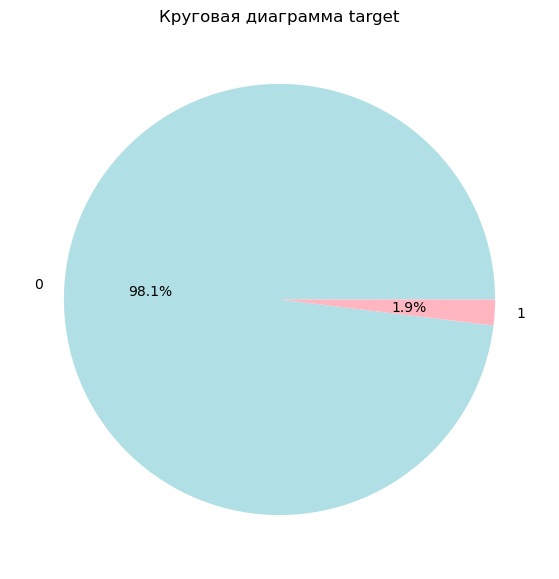

In [173]:
plot_pie(df, target) 

Для клиентов, которые не получают рассылки:

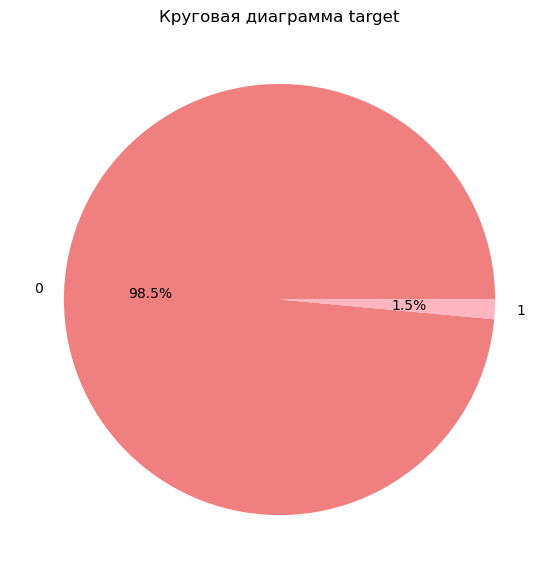

In [174]:
plot_pie(df[df['messages_per_client'].isna()], target) 

Клиенты, которые получают рассылки:

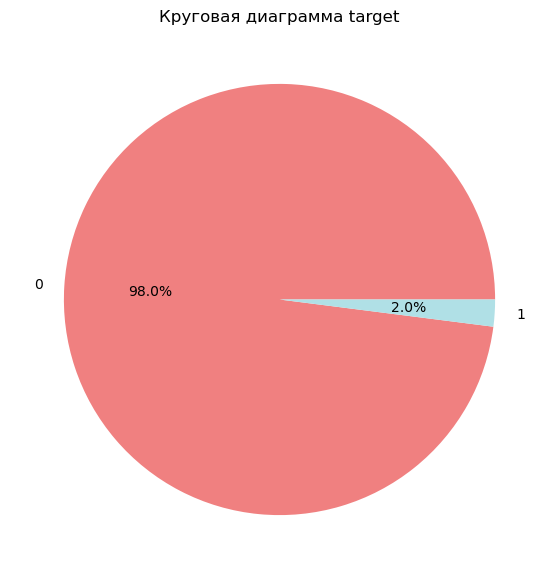

In [175]:
df_target_pie = df.dropna()
plot_pie(df_target_pie, target) 

Как видим, в данных наблюдается очень сильный дизбаланс классов, меньше 2 % клиентов совершили покупку в целевом периоде. Также можно отметить, что существует разница в покупательском поведении у клиентов, которые получают рассылки и клиентов, которые рассылки не получают. Хотя `0,5 %`  на первый взгляд это совсем немного, в данном контексте это может говорить об отличиях поведения клиентов и, возможно, для клиентов, которые не получают рассылки, стоит рассмотреть другие каналы привлечения, такие как социальные сети, публикация статей, видео-контент (ютуб, тикток), контекстная реклама, чат-боты (использование чат-ботов для взаимодействия с клиентами в мессенджерах и на сайте) и другие.   

In [176]:
cat_cols = ['active_last_30_days', 'active_last_60_days']
num_cols = [
    'purchase_count', 
    'total_spent', 
    'average_purchase_value', 
    'max_purchase_value', 
    'min_purchase_value', 
    'usage_duration', 
    'unique_categories_count',
    'average_spent_favorite',
    'messages_per_client',
    'opens_per_client',
    'clicks_per_client',
    'messages_email',
    'messages_push',
    'unique_campaigns_per_client',
    'events_per_client',
    'open_rate_per_client'
]

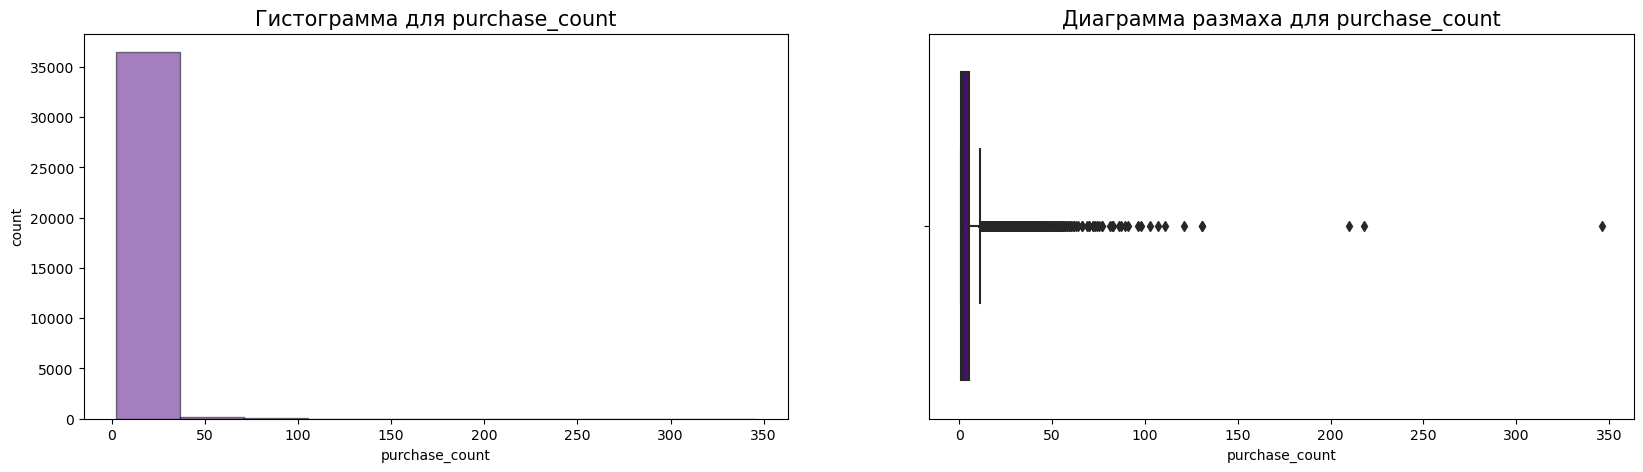

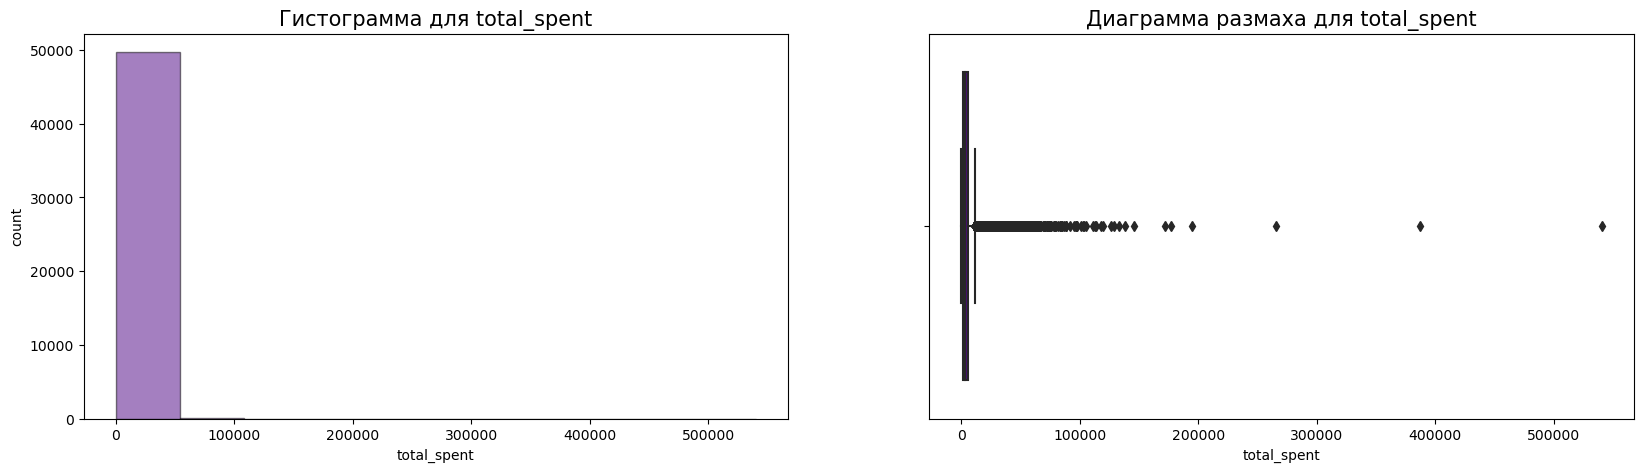

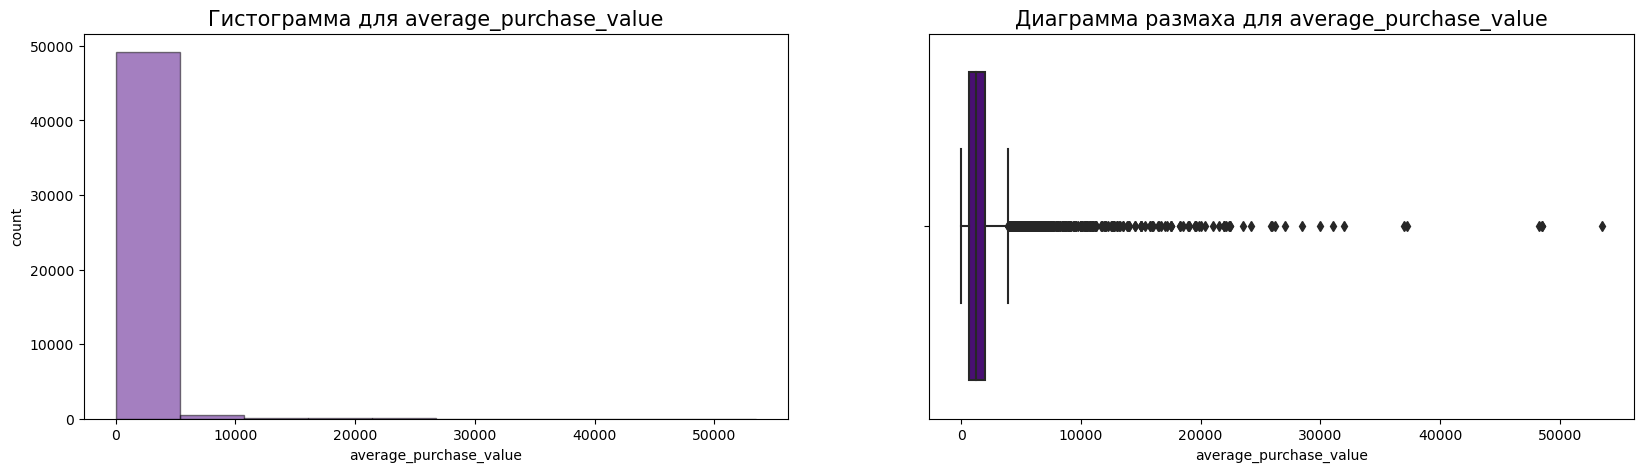

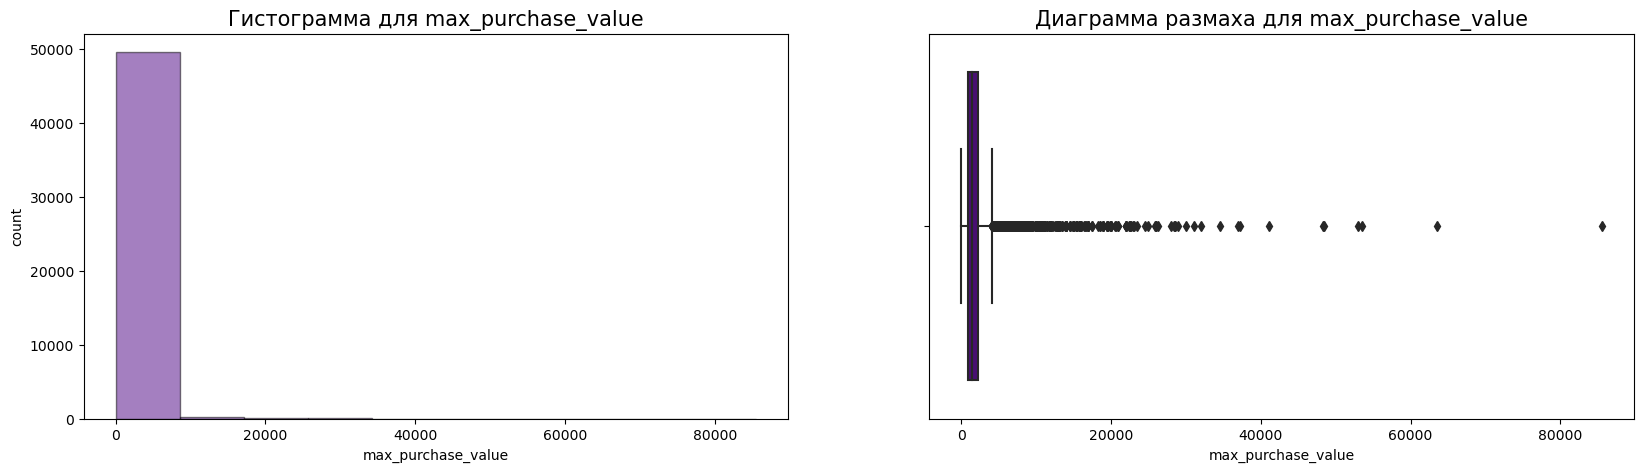

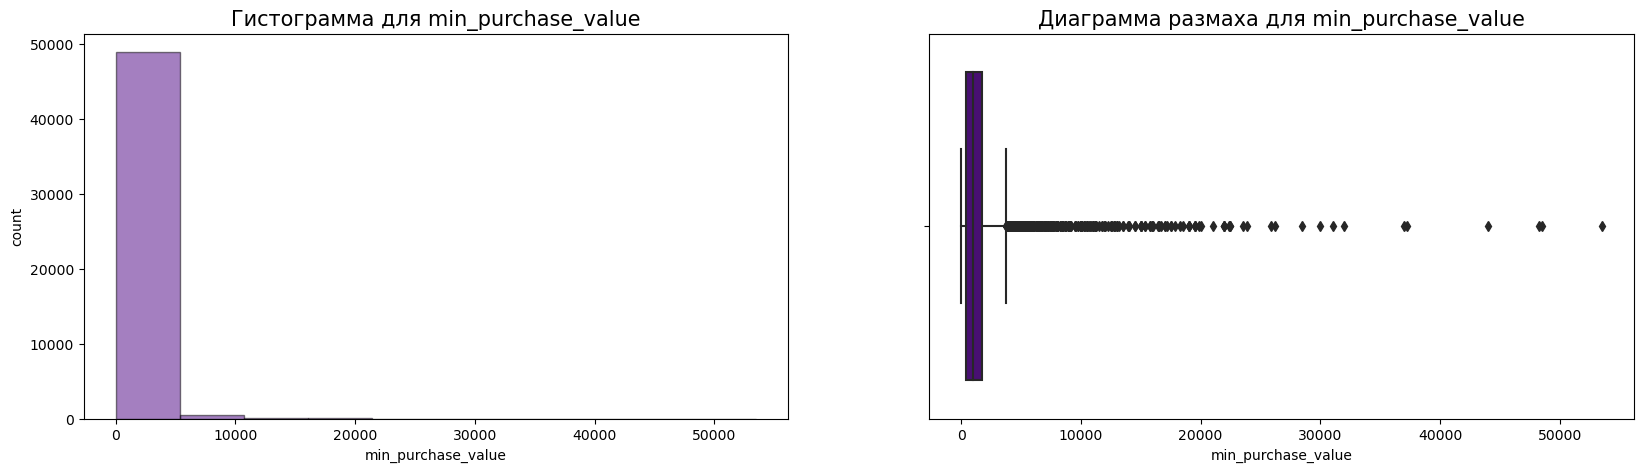

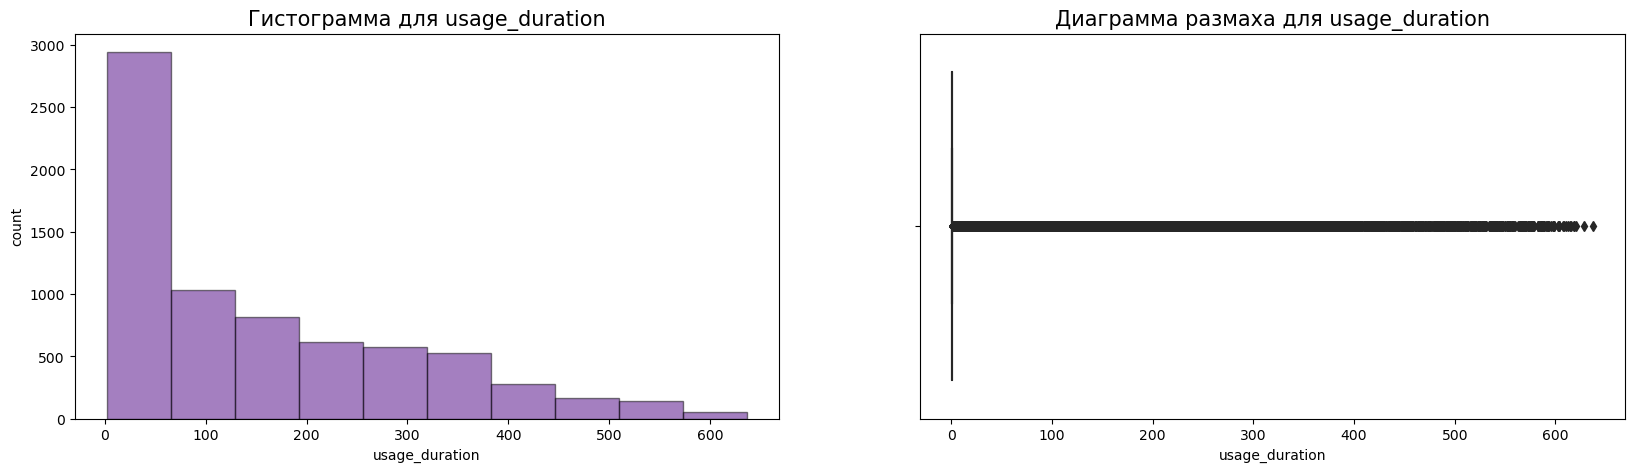

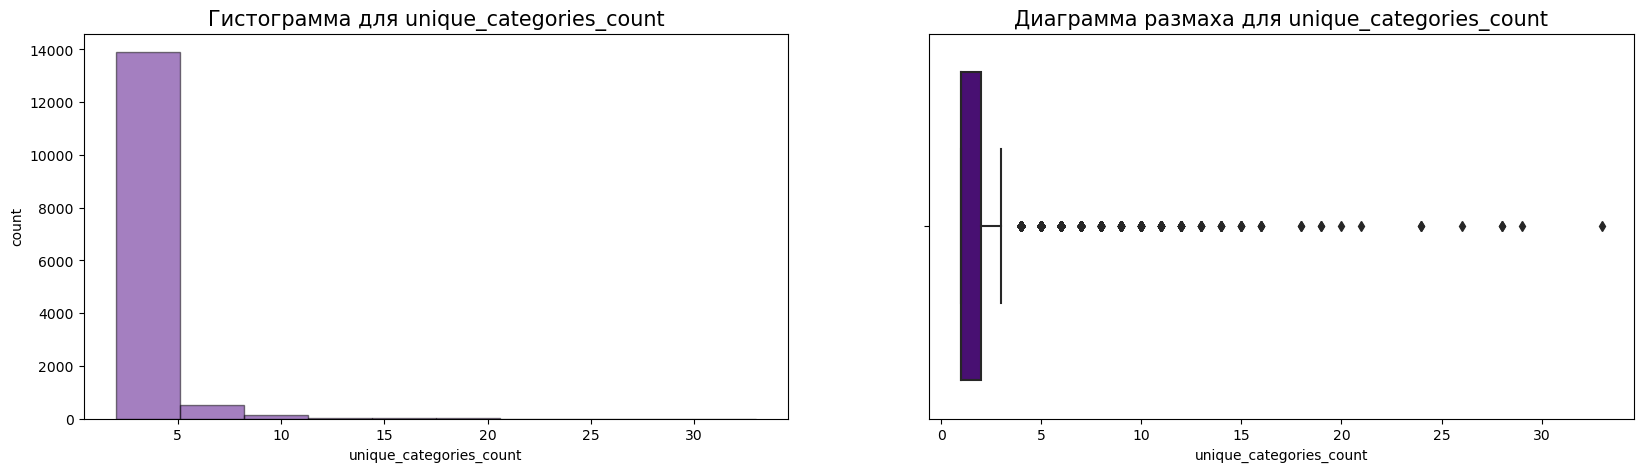

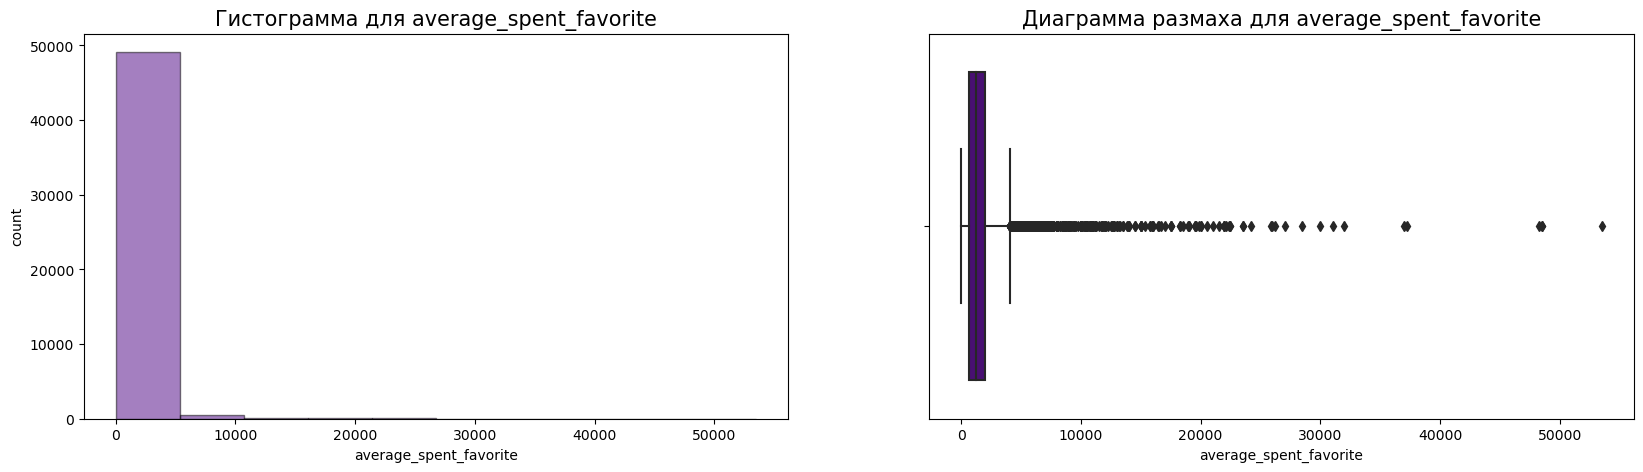

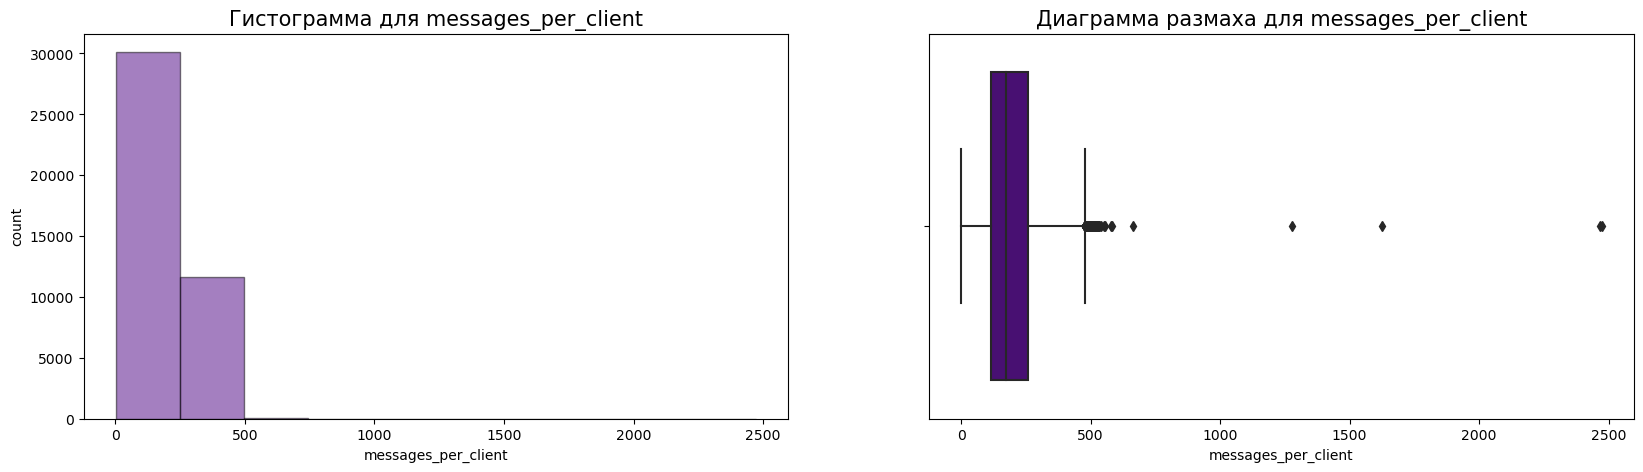

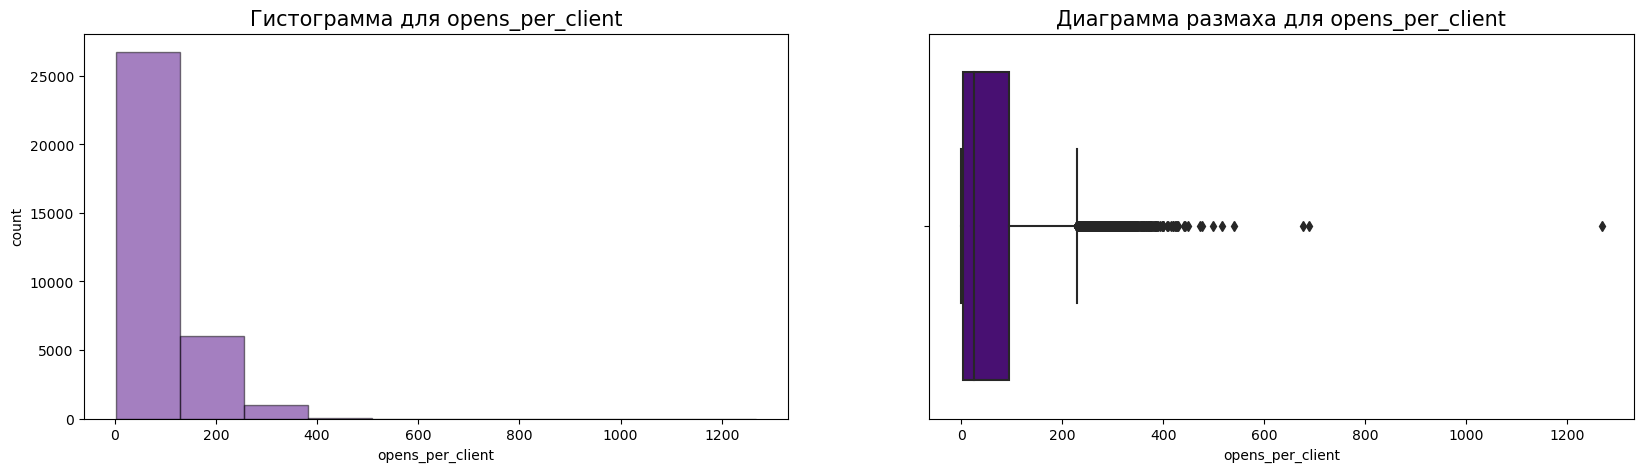

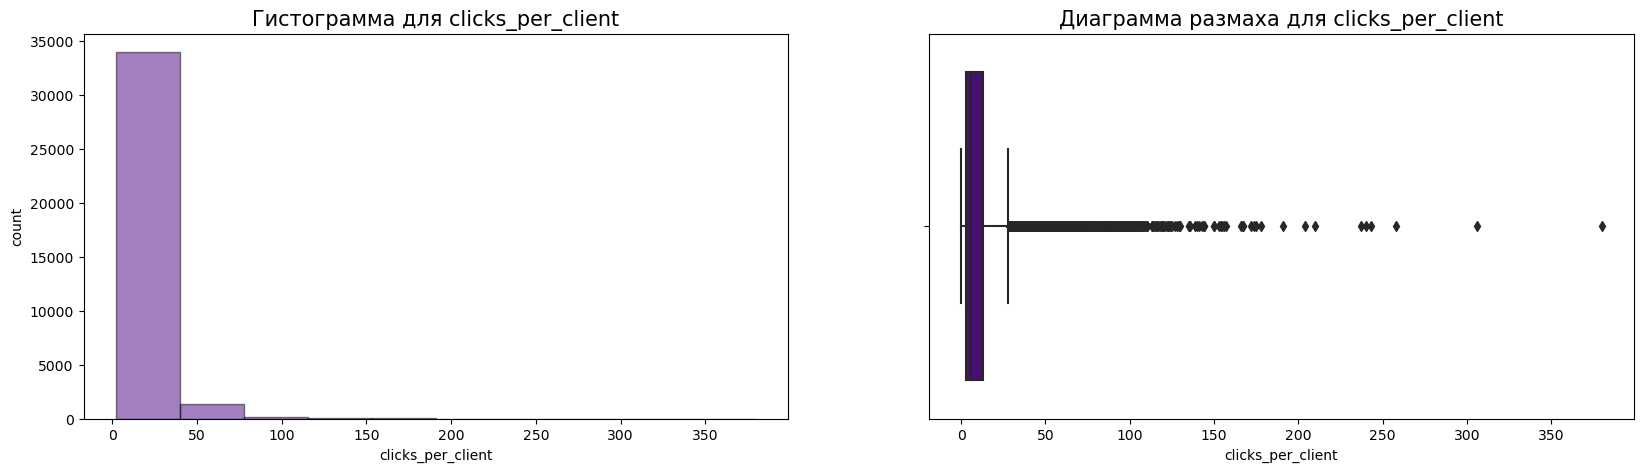

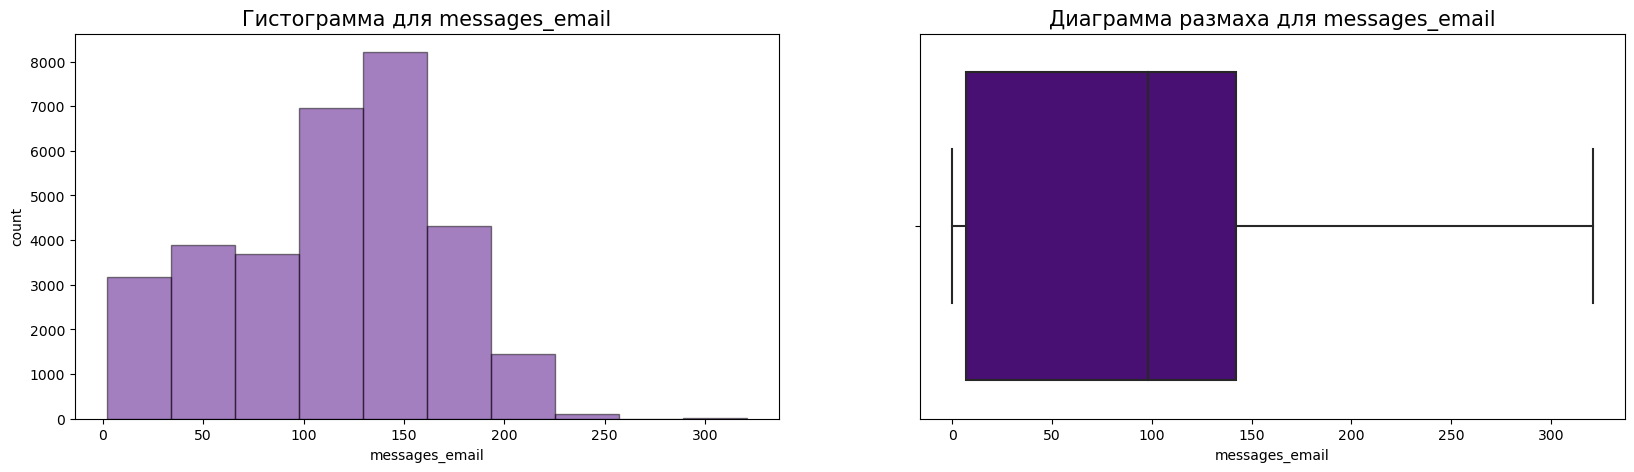

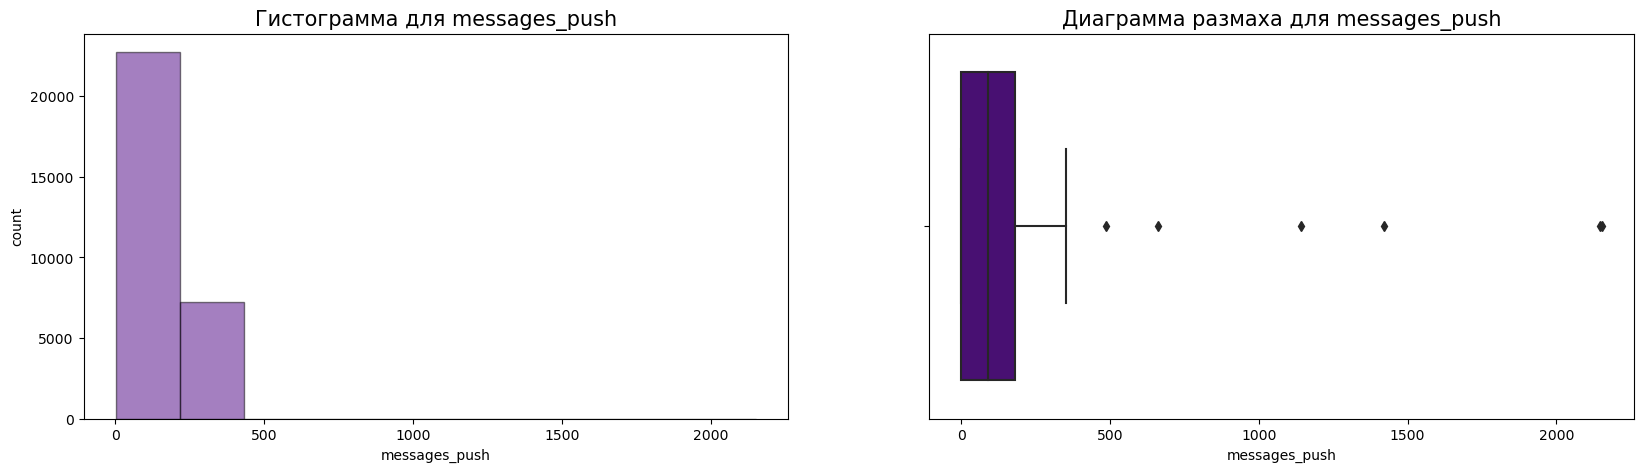

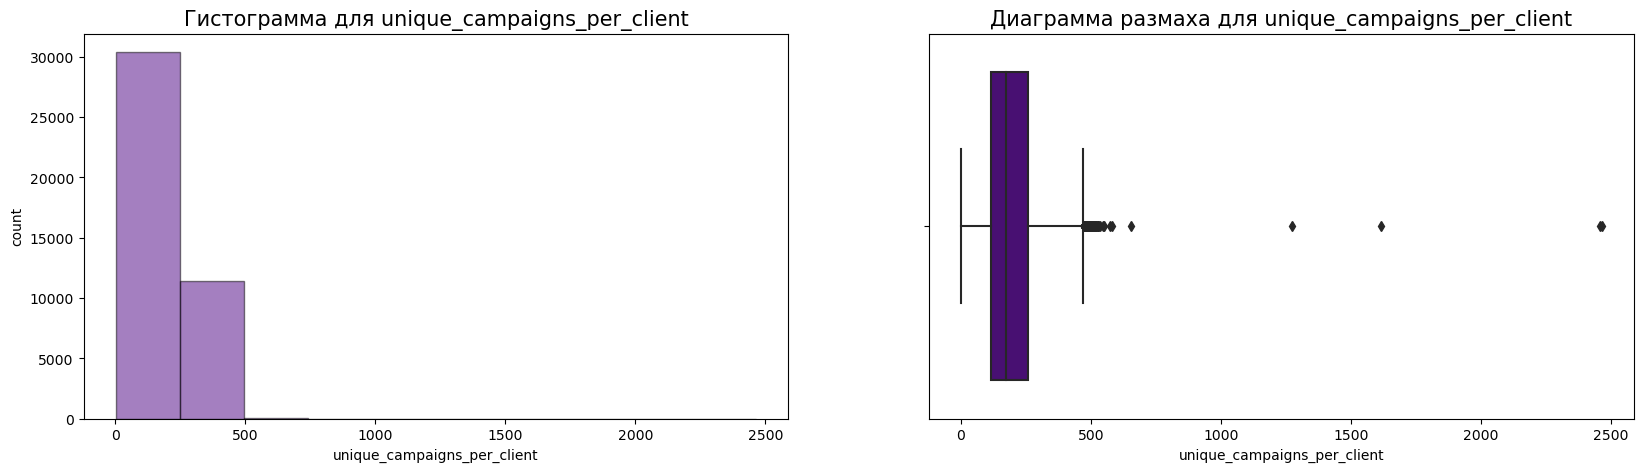

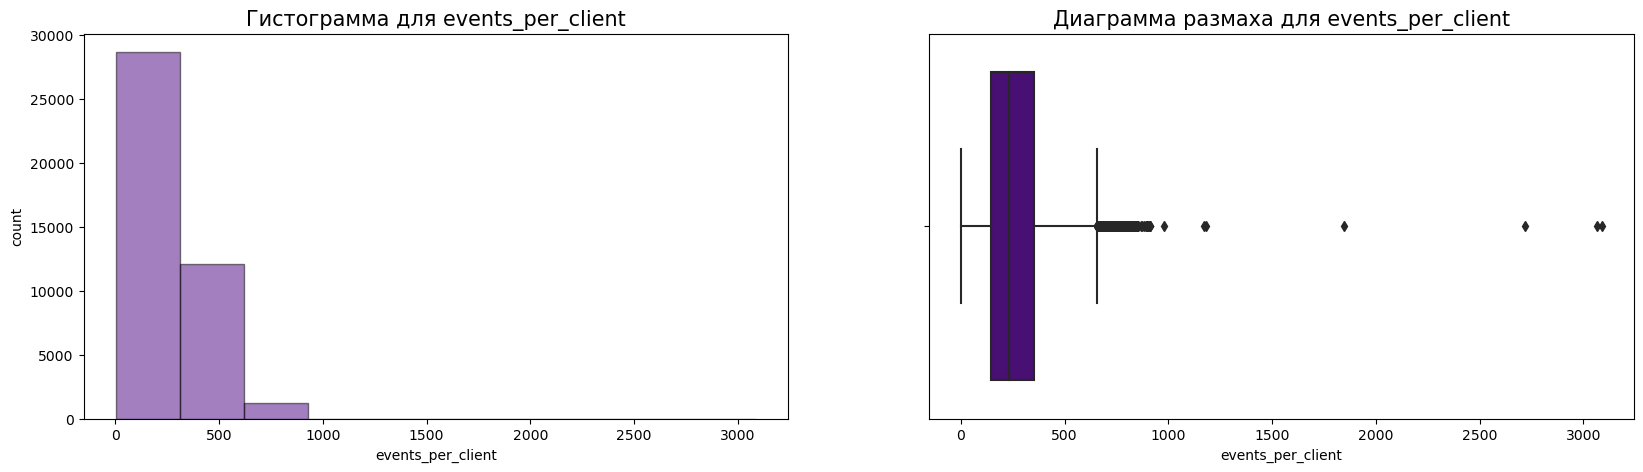

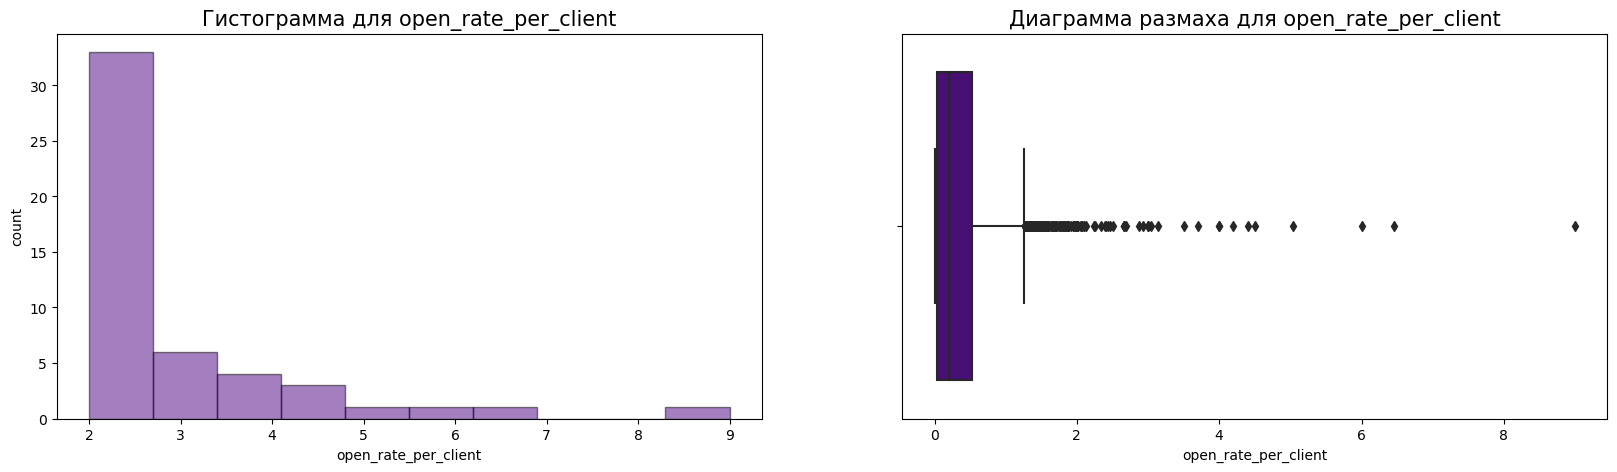

In [177]:
hist_boxplot(df, num_cols)

Можем видеть, что почти на всех графиках данные сконцентрированы около нуля. Вообще задача усложняется тем, что кроме высокого дизбаланса классов четверть клиентов совершили только одну покупку:

In [178]:
print('Клиентов, совершивших одну покупку, по отношению к количеству клиентов, совершавших покупки:',
      round(len(df[df['purchase_count'] == 1]) / len(df[df['purchase_count'] > 0]), 2) * 100, '%')

Клиентов, совершивших одну покупку, по отношению к количеству клиентов, совершавших покупки: 26.0 %


Это может указывать на проблемы с удержанием клиентов. Возможно, стоит рассмотреть стратегии для повышения лояльности клиентов, такие как программы лояльности, скидки на повторные покупки или улучшение качества обслуживания.

Маркетинговые стратегии: Понимание того, что значительная часть клиентов совершает только одну покупку, может помочь адаптировать маркетинговые кампании. Например, нацелить рекламные кампании на клиентов, которые совершили только одну покупку, с предложениями, которые побудят их вернуться.

Анализ продукта: Проанализируем, какие продукты покупают клиенты, совершающие только одну покупку. Это может помочь выявить продукты, которые не удовлетворяют ожидания клиентов, и улучшить их.

Кроме того, что в основном наблюдения концентрируются около нуля, видим много экстремально высоких значений почти во всех столбцах. Попробуем удалить и обучить модель без них.

Проанализируем категориальные признаки. Посмотрим активность покупателей за последние 30/60 дней:

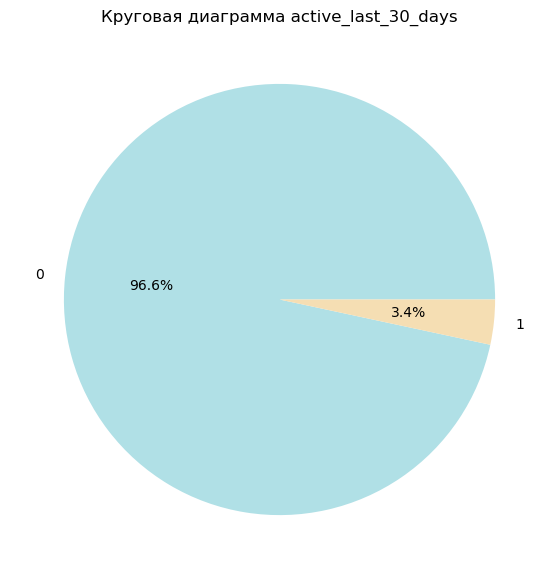

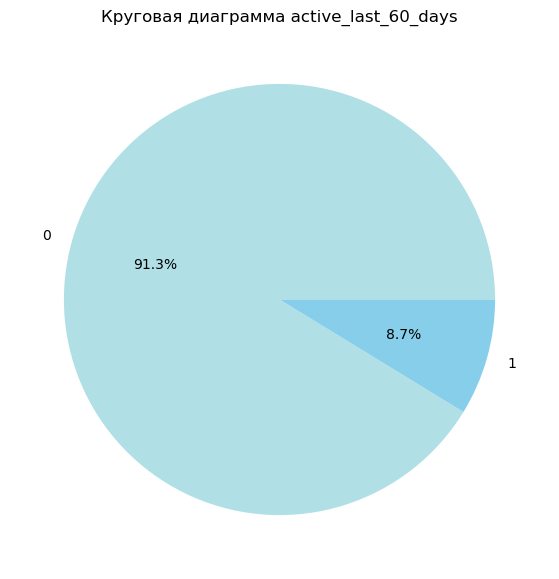

In [179]:
plot_pie(df, cat_cols)

Большинство покупателей не были активны за последние 30/60 дней. Это также может говорить о наличии проблемы с удержанием клиентов.

Посмотрим любимые категории для всех клиентов и отдельно для клиентов, совершивших одну покупку:

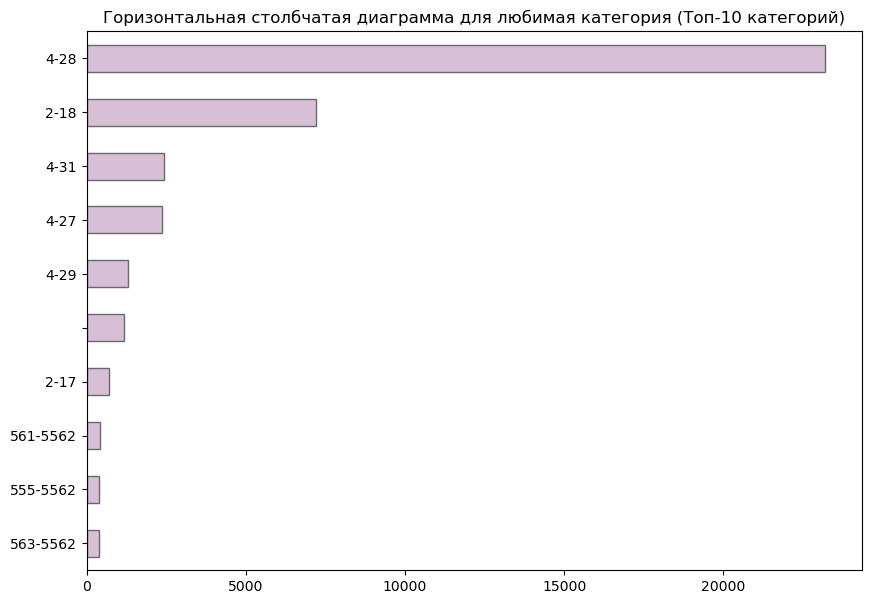

In [180]:
cat_features = ['favorite_category']
cat_features_ru = {'favorite_category': 'любимая категория'}
plot_bar_top_10(df, cat_features, cat_features_ru)

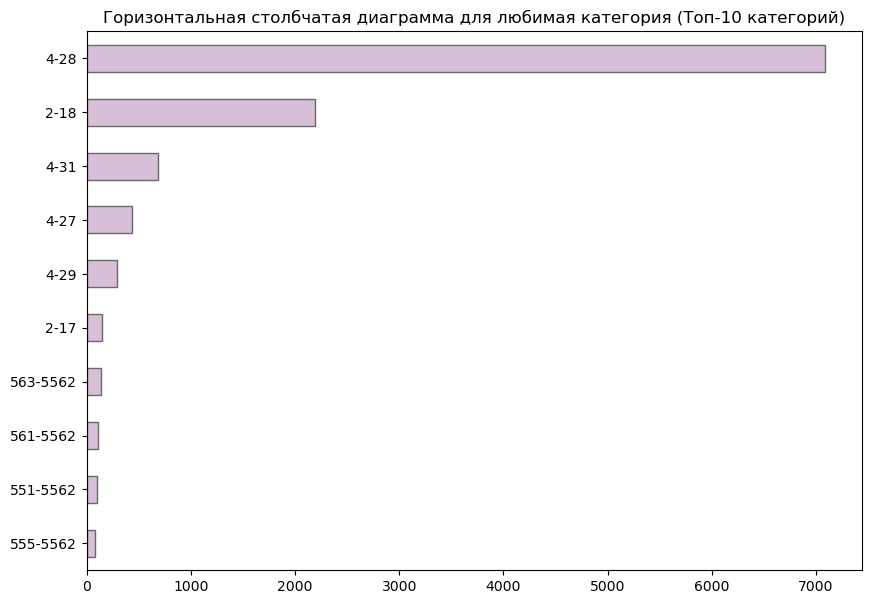

In [181]:
plot_bar_top_10(df[df['purchase_count'] == 1], cat_features, cat_features_ru)   

Существенных различий в любимых категориях для клиентов не наблюдается.

### Корреляционный анализ

Мы создали много разных признаков, посмотрим, как они коррелируют друг с другом.

In [182]:
phik_matrix = df.phik_matrix(interval_cols=num_cols)

C:\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable clicks_to_purchase_ratio is large: 1093. Are you sure this is not an interval variable? Analysis for pairs of variables including clicks_to_purchase_ratio can be slow.
  warnings.warn(


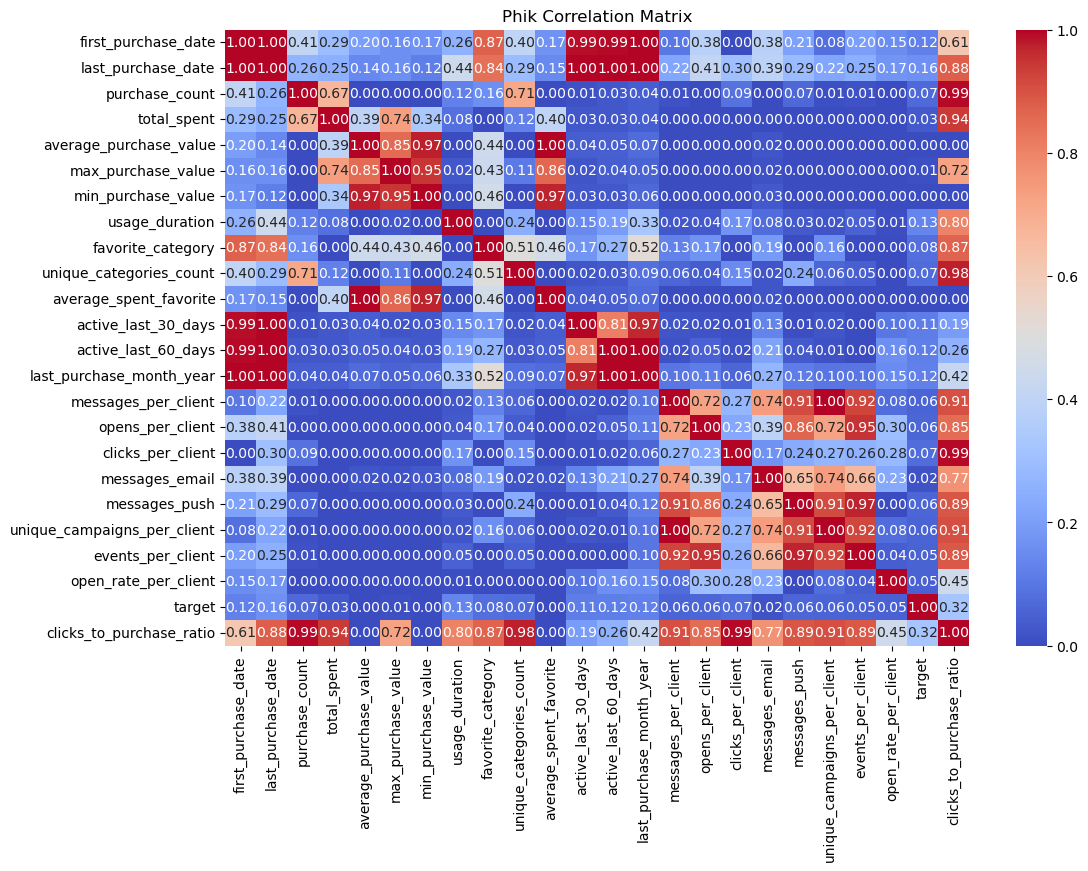

In [183]:
plt.figure(figsize=(12,8))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Phik Correlation Matrix')
plt.show();

Некоторые признаки имеют очень высокую корреляцию друг с другом, при этом с таргетом только один признак `clicks_to_purchase_ratio` имеет корреляцию 0.3. Попробуем обучить модель, используя разные варианты комбинаций фичей.

### Вывод

В данных наблюдается очень сильный дизбаланс классов: меньше 2 % клиентов совершили покупку в целевом периоде. Также можно отметить, что существует разница в покупательском поведении у клиентов, которые получают рассылки и клиентов, которые рассылки не получают. Четверть клиентов совершили только одну покупку. Это может указывать на проблемы с удержанием клиентов. Возможно, стоит рассмотреть стратегии для повышения лояльности клиентов, такие как программы лояльности, скидки на повторные покупки или улучшение качества обслуживания. 

## Обучение модели

Заполним нулями пропуски в количественных признаках (маркетинговое взаимодействие)

In [184]:
df[num_cols] = df[num_cols].fillna(0)

Задаем гиперпараметры для перебора на кросс-валидации:

In [185]:
param_dist = {
    'learning_rate': [0.01, 0.05],
    'num_leaves': [10, 50],
    'max_depth': [10, 15],
    'min_child_samples': [30, 50, 70],
    'colsample_bytree': [0.8, 1.0],
    'subsample': [0.8, 0.9],
    'n_estimators': [50, 100]
}

<div class="alert alert-info">
<h2> Комментарий<a class="tocSkip"> </h2>
здесь было множество разных вариаций, я опишу это в итоговом выводе. категориальные признаки вообще не пригодились
    

</div>

Уберем из датасета признаки, имеющие высокую корреляцию друг с другом и категориальные признаки. Экспериментально удалось выяснить, что они создают шум.

In [186]:
df_modeling = df.drop(['first_purchase_date', 'last_purchase_date', 
            'average_purchase_value', 'average_spent_favorite', 'max_purchase_value',
            'active_last_30_days', 'unique_campaigns_per_client', 'events_per_client', 
            'messages_push', 'favorite_category', 'last_purchase_month_year',
            'clicks_to_purchase_ratio'], axis=1)

In [187]:
phik_matrix = df_modeling.phik_matrix(interval_cols=num_cols)

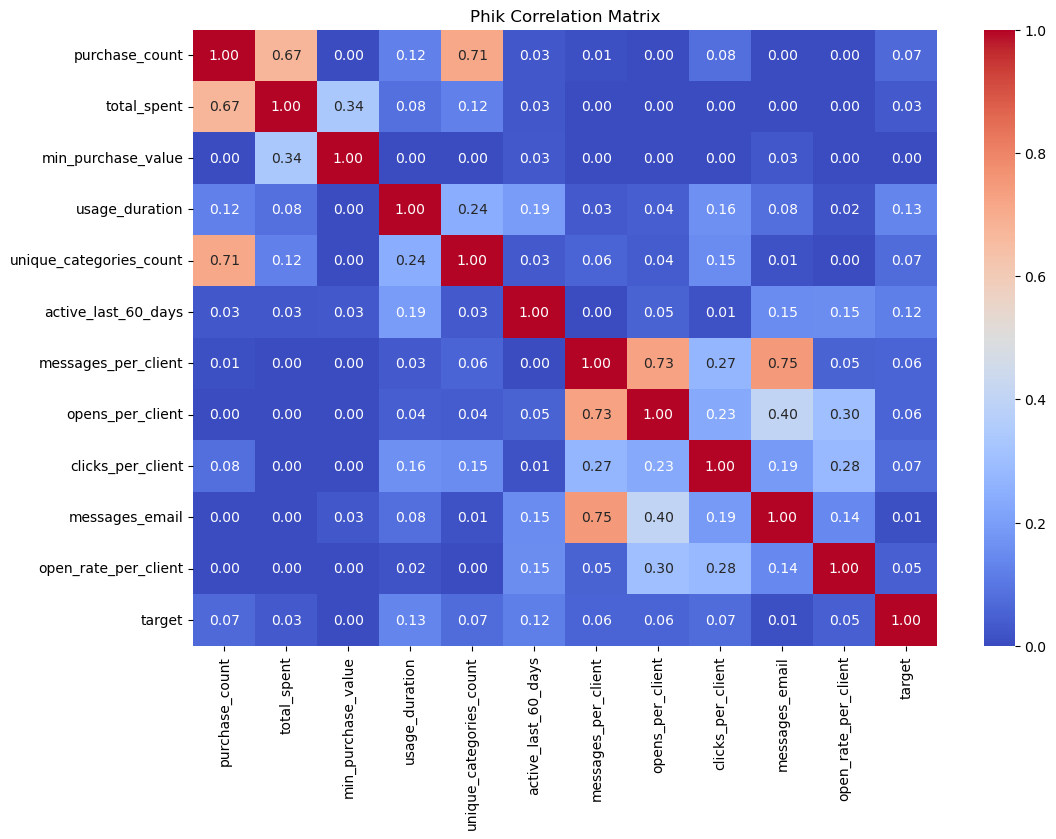

In [188]:
plt.figure(figsize=(12,8))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Phik Correlation Matrix')
plt.show();

Разделим данные на входные признаки и целевую переменную

In [189]:
X = df_modeling.drop('target', axis=1)
y = df_modeling['target']

Создадим и обучим модель LightGBM, подберем для нее лучшие гиперпараметры

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

lgbm_model = lgb.LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE)
lgbm_model.fit(X_train, y_train)


grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_dist, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

best_score = grid_search.best_score_
print(f'Кросс-валидационная метрика ROC-AUC: {best_score:.2f}')


[LightGBM] [Info] Number of positive: 740, number of negative: 39139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1978
[LightGBM] [Info] Number of data points in the train set: 39879, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Fitting 5 folds for each of 192 candidates, totalling 960 fits
[LightGBM] [Info] Number of positive: 740, number of negative: 39139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1978
[LightGBM] [Info] Number of data points in the train set: 39879, number of used features: 11
[LightGBM] [Info] [binary

C:\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [191]:
print("Лучшие параметры для градиентного бустинга:")
print(grid_search.best_params_)

Лучшие параметры для градиентного бустинга:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 70, 'n_estimators': 50, 'num_leaves': 10, 'subsample': 0.8}


### Оценка модели с использованием метрики ROC-AUC

In [192]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC на тестовых данных: {roc_auc:.2f}')

ROC-AUC на тестовых данных: 0.74


### Feature Importance

Построим `Feature importance` типа `split` — он показывает, сколько раз признак использовался для разделения данных в деревьях решений.

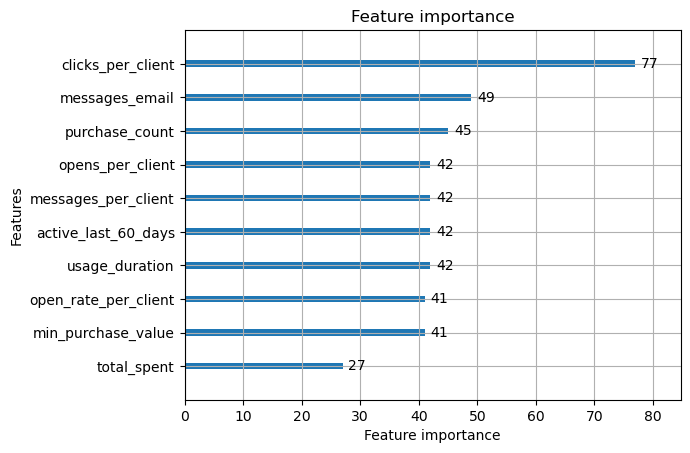

In [193]:
lgb.plot_importance(best_model, max_num_features=10, importance_type='split', title='Feature importance')
plt.show()

`gain` показывает суммарное увеличение качества модели, которое было достигнуто благодаря использованию признака для разбиения узла.

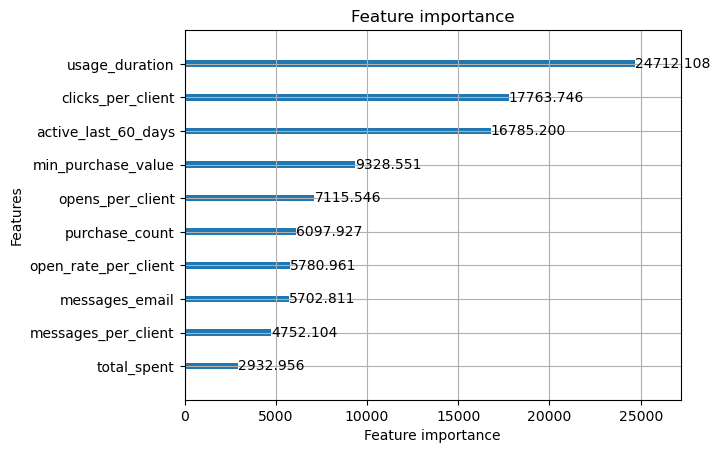

In [194]:
lgb.plot_importance(best_model, max_num_features=10, importance_type='gain', title='Feature importance')
plt.show()

Также построим график `SHAP` —  значения показывают вклад каждого признака в предсказание для каждого отдельного наблюдения. Это позволяет понять, как каждый признак влияет на предсказания модели.

C:\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


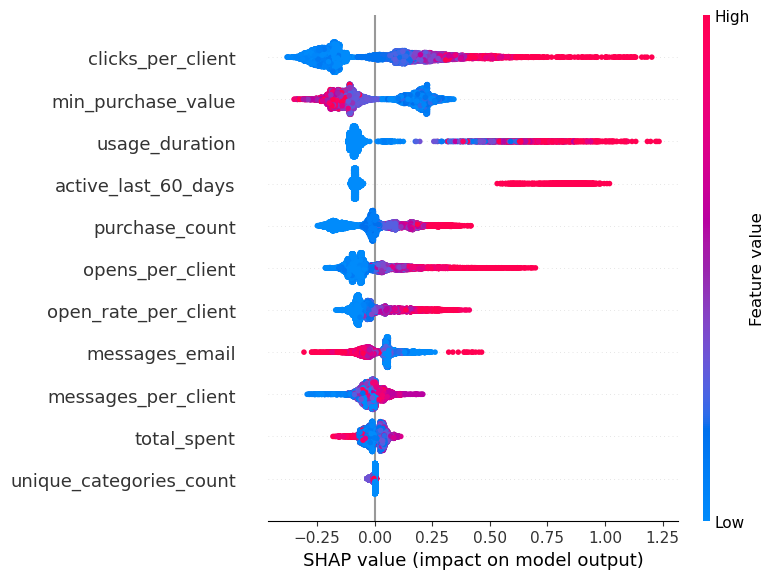

In [195]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

### Вывод

Наиболее важными признаками для модели оказались:
- `clicks_per_client`
- `min_purchase_value`
- `usage_duration`
- `active_last_60_days`
- `purchase_count`

1. `clicks_per_client`:

Высокое количество кликов может указывать на заинтересованность клиента в продуктах, но если это не приводит к покупкам, возможно, есть проблемы с удобством использования сайта или процессом оформления заказа.
Можно опробовать улучшить пользовательский интерфейс и упростить процесс оформления заказа.

2. `min_purchase_value`:

Низкая минимальная стоимость покупки может указывать на то, что клиенты делают небольшие покупки. Это может быть связано с недоверием к продукту или недостатком информации.
Можно попробовать предложить скидки или бонусы за более крупные покупки, улучшить описание продуктов и предоставьте больше отзывов клиентов, чтобы повысить доверие.

3. `usage_duration`:

Длительное использование сайта может указывать на заинтересованность клиента, но если это не приводит к покупкам, возможно, есть проблемы с навигацией или поиском нужных товаров.
Можно попробовать улучшить навигацию по сайту и добавить функции поиска и фильтрации товаров, провести анализ пользовательского опыта, чтобы выявить и устранить проблемы.

4. `active_last_60_days`:

Если клиенты не были активны за последние 60 дней, это может указывать на потерю интереса или неудовлетворенность.
Как вариант, можно провести кампании по возврату клиентов, предложив специальные предложения и скидки для тех, кто не был активен в последнее время с использованием email-рассылок и push-уведомлений.

5. `purchase_count`:

Низкое количество покупок может указывать на проблемы с удержанием клиентов.
Можно попробовать внедрить программы лояльности, предложить бонусы за повторные покупки и улучшить качество обслуживания клиентов. Провести опросы, чтобы понять, что мешает клиентам возвращаться.

## Общий вывод

В ходе работы над проектом и для создания новых признаков было использовано три датасета: с данными о покупках, о сообщениях (маркетинговом взаимодействии), таргет (совершил ли клиент покупку в целевом периоде). Я создала ряд агрегированных признаков и попробовала следующие стратегии для обучения модели:

- изначально обучила модель на всех признаках, включая скоррелированные, сразу достигла метрики 69-70;
- для борьбы с дисбалансом классов использовала технику оверсемплинга `SMOTE (Synthetic Minority Over-sampling Technique)`, которая позволяет создавать синтетические образцы для минорного класса. Получила метрику `ROC-AUC` на валидационной в районе 98-100, при этом на тестовой выборке метрика упала до уровня 65-67. От использования техники `SMOTE` отказалась в пользу настройки модели с параметром `class_weight='balanced'`, что в целом не сильно сказывается на тестовой выборке, но снижает переобучение;
- удаление экстремальных значений с верхней границы, при этом нижние значения не трогала, так как там сосредоточена большая часть наблюдений. Среди них содержится примерно 20 % целевого класса 1, поэтому метрика упала на 3-4 пункта;
- пробовала стратегии заполнения пропусков в наблюдениях для покупателей, которые не получают рекламных сообщений, медианой, а также удаление этих строк. В целом на метрике это не сказалось, поэтому оставила нули, так как это представляется в данном случае наиболее подходящим решением;
- при использовании категориальных признаков `favorite_category` и `last_purchase_month_year` получила метрику 70, при этом на графике важности признаков `lgbm-split` они вышли на первые два места соответственно, но на графике важности `SHAP` было показано, что признаки шумные, их удаление позволило повысить метрику до 74.

Хотелось бы обратить внимание заказчика на качество данных:
- Данные сильно несбалансированы, что затрудняет анализ, в дальнейшем хотелось бы, чтобы выборка для анализа содержала данные об обоих целевых классах клиентов;
- столбцы `message_id` в датасетах с покупками с сообщениями состоят из идентификатора покупателя, рекламной кампании и уникального идентификатора сообщения. При этом идентификатор покупателя не всегда совпадает со значением из столбца `client_id`, что говорит о возможной проблеме при сборе данных;
- столбец  `category_ids` в датасете с покупками частично содержит строки, которые выглядят как списки, что также может говорить о проблеме при сборе данных;
- столбец `date` в `purchases` не содержит времени совершения покупки, что не позволяет понять, являются ли строки дубликатами или же это идентичные покупки, совершенные в один день.

Общие рекомендации для бизнеса: 

Удержание клиентов: Разработать программы лояльности и специальные предложения для клиентов, которые не были активны за последние 30/60 дней.

Персонализация: Использовать данные о предпочтениях клиентов для персонализированных предложений и рекомендаций.

Маркетинговые кампании: Провести целевые маркетинговые кампании для клиентов, которые совершили только одну покупку, чтобы побудить их вернуться.

In [196]:
print('все обработалось корректно')

все обработалось корректно
